In [32]:
import re
import csv
import math
import nltk
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
from Index import Index
from matplotlib import pyplot as plt 

In [2]:
index = Index(('DS\\index.json', 'DS\\inverted.json', 'DS\\queries.json', 'DS\\ground_truth.csv', 'DS\\raw_queries.json', 'DS\\raw_docs.json'), preprocessed=True)

# Predictions

## Vector

In [3]:
predicted_scalar = index.vector_search(max_docs=1460, metric='scalar') 
index.PR([[i[0] for i in j] for j in list(predicted_scalar.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [00:51<00:00,  1.48it/s]


(0.028037130497476574, 0.9994801089185152)

In [4]:
with open('Predictions\\pred_scalar.json', 'w', encoding='utf-8') as f: 
    json.dump({str(k): v for k, v in predicted_scalar.items()}, f, ensure_ascii=False, indent=4) 

In [5]:
predicted_cos = index.vector_search(max_docs=1460, metric='cosine')
index.PR([[i[0] for i in j] for j in list(predicted_cos.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [00:58<00:00,  1.29it/s]


(0.028037130497476574, 0.9994801089185152)

In [6]:
with open('Predictions\\pred_cos.json', 'w', encoding='utf-8') as f: 
    json.dump({str(k): v for k, v in predicted_cos.items()}, f, ensure_ascii=False, indent=4) 

In [7]:
predicted_jacc = index.vector_search(max_docs=1460, metric='jaccard') 
index.PR([[i[0] for i in j] for j in list(predicted_jacc.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [02:02<00:00,  1.62s/it]


(0.028037130497476574, 0.9994801089185152)

In [8]:
with open('Predictions\\pred_jacc.json', 'w', encoding='utf-8') as f:
    json.dump({str(k): v for k, v in predicted_jacc.items()}, f, ensure_ascii=False, indent=4) 

## BM25

In [9]:
predicted_bm25 = index.BM25() 
index.PR([[i[0] for i in j[:25]] for j in predicted_bm25], index.relevent_docs)[2:] 

100%|██████████| 76/76 [00:09<00:00,  8.40it/s]


(0.052105263157894745, 0.03607191392734016)

In [10]:
predicted_bm25 = [[[str(i), l] for i, l in j] for j in predicted_bm25]
predicted_bm25 = {str(i): j for i, j in enumerate(predicted_bm25)}

In [11]:
with open('Predictions\\pred_bm25.json', 'w', encoding='utf-8') as f:
    json.dump(predicted_bm25, f, ensure_ascii=False, indent=4)

## Bool

In [12]:
docs = index.parse_boolean_query('structures and (structural or formulas) and (not drawing and compounds) or chemical') 

# Evaluation

In [13]:
def read_json(file):
    with open(file) as f:
        return json.load(f)

In [14]:
predicted_scalar = read_json('Predictions\\pred_scalar.json')
predicted_cos = read_json('Predictions\\pred_cos.json')
predicted_jacc = read_json('Predictions\\pred_jacc.json')
predicted_bm25 = read_json('Predictions\\pred_bm25.json')

In [15]:
preds = [predicted_scalar, predicted_cos, predicted_jacc, predicted_bm25]

In [16]:
def precision(i, pred, relevent):
    pred = [[i[0] for i in j[:i]] for j in list(pred.values())]
    return index.PR(pred, index.relevent_docs)[2]

In [17]:
def recall(i, pred, relevent):
    pred = [[i[0] for i in j[:i]] for j in list(pred.values())]
    return index.PR(pred, index.relevent_docs)[3]

In [18]:
def mrr(i, pred, relevent):
    pred = [[i[0] for i in j[:i]] for j in list(pred.values())]
    scores = []
    for p, r in zip(pred, relevent):
        for i, j in enumerate(p):
            j = int(j)
            if j in r:
                scores.append(1/(i+1))
                break
    return np.sum(scores) / len(pred)

## P5 and P10

In [19]:
rel = [[i-1 for i in j] for j in index.relevent_docs]

In [20]:
for pred in preds:
    print(precision(5, pred, index.relevent_docs)) 

0.05000000000000001
0.06315789473684211
0.08157894736842107
0.04736842105263159


In [21]:
for pred in preds:
    print(precision(10, pred, index.relevent_docs))

0.05394736842105264
0.06052631578947368
0.06842105263157895
0.05526315789473685


## MRR5 and MRR10

In [22]:
for pred in preds:
    print(mrr(5, pred, index.relevent_docs))

0.08048245614035088
0.12807017543859647
0.14758771929824563
0.12061403508771931


In [23]:
for pred in preds:
    print(mrr(10, pred, index.relevent_docs))

0.10149331662489558
0.1515873015873016
0.17022765246449456
0.14251253132832079


## PR

In [24]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def PR_curve(pred, relevent, step=10):
    PR = []
    for thresh in range(1, step):
        PR.append(index.PR([[i[0] for i in j[:thresh]] for j in list(pred.values())], relevent)[2:])
    PR = np.array(PR)
    curve = []
    recalls = list(frange(0, 1.01, 1/(10*len(PR))))
    for r, pr in zip(recalls, PR):
        filtered = [i[0] for i in PR if i[1] >= r]
        p = max(filtered) if filtered else 0
        curve.append((p, r)) 
    return curve

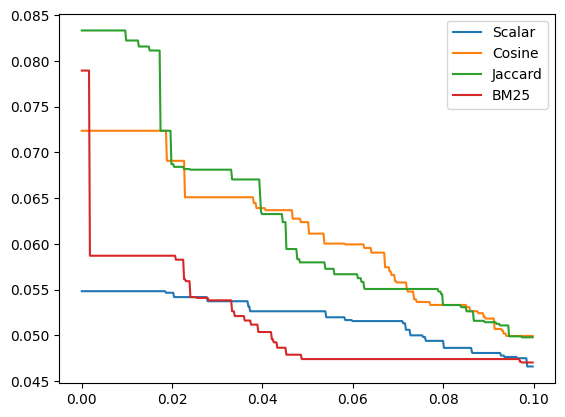

In [25]:
rocs = [] 
models = ['Scalar', 'Cosine', 'Jaccard', 'BM25']
for pred in preds:
    rocs.append(np.array(PR_curve(pred, index.relevent_docs, 500))) 

for roc, model in zip(rocs, models):
    plt.plot(roc[:, 1], roc[:, 0], label=model) 
plt.legend()
plt.show() 

In [26]:
for name, roc in zip(models, rocs):
    np.save('Eval//PR_'+name, roc)

## ROC

In [33]:
def roc(pred, relevent, thresh=10):
    fpr, tpr = [], []
    for i in tqdm(range(thresh)):
        f, t = [], []
        for p, r in zip(pred, relevent):
            p = p[:i]
            TP = len(set(p) & set(r))
            FP = len([i for i in p if i not in r])
            f.append(FP/(1460-len(r)))
            t.append(TP/len(r))
        fpr.append(np.mean(f))
        tpr.append(np.mean(t))
    return fpr, tpr

100%|██████████| 1400/1400 [00:34<00:00, 40.54it/s]


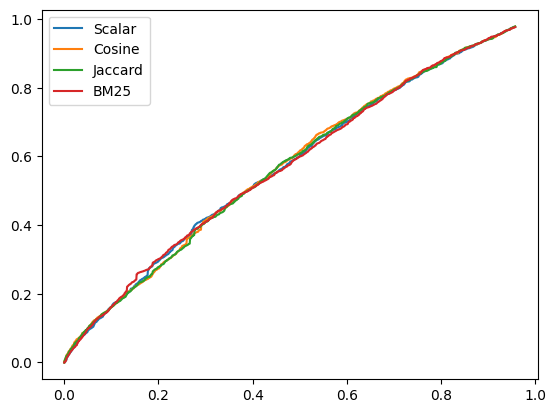

In [34]:
for pred, name in zip(preds, models):
    fpr, tpr = roc([[int(i[0]) for i in j] for j in pred.values()], index.relevent_docs, 1400)
    np.save('Eval//ROC_'+name, np.array([fpr, tpr]))
    plt.plot(fpr, tpr, label=name)
plt.legend()
plt.show()

## Summary

In [35]:
eval = []
names = ['Scalar', 'Cosine', 'Jaccard']
for pred, name in zip(preds, names):
    p5 = round(precision(5, pred, index.relevent_docs), 3)
    p10 = round(precision(10, pred, index.relevent_docs), 3)
    r5 = round(recall(5, pred, index.relevent_docs), 3)
    r10 = round(recall(10, pred, index.relevent_docs), 3)
    m5 = round(mrr(5, pred, index.relevent_docs), 3)
    m10 = round(mrr(10, pred, index.relevent_docs), 3)
    eval.append([name, p5, r5, round((2*p5*r5)/(p5+r5), 3), m5, p10, r10, round((2*p10*r10)/(p10+r10), 3), m10])

eval = pd.DataFrame(eval)
eval.columns = ['Model', 'P5', 'R5', 'F5', 'MRR5', 'P10', 'R10', 'F10', 'MRR10']
eval.to_csv('Eval//Eval_Vector.csv') 

In [36]:
eval = pd.read_csv('Eval//Eval_Vector.csv')
eval.drop([eval.columns[0]], axis=1) 

,Model,P5,R5,F5,MRR5,P10,R10,F10,MRR10
0,Scalar,0.050,0.007,0.012,0.080,0.054,0.016,0.025,0.101
1,Cosine,0.063,0.012,0.020,0.128,0.061,0.024,0.034,0.152
2,Jaccard,0.082,0.015,0.025,0.148,0.068,0.023,0.034,0.170


In [37]:
eval = []
names = ['BM25']
for pred, name in zip(preds, names):
    p = round(precision(25, pred, index.relevent_docs), 4)
    r = round(recall(25, pred, index.relevent_docs), 4)
    m = round(mrr(25, pred, index.relevent_docs), 4)
    eval.append([name, p, r, round((2*p*r)/(p+r), 4), m])

eval = pd.DataFrame(eval)
eval.columns = ['Model', 'Precision', 'Recall', 'F-score', 'MRR']
eval.to_csv('Eval//Eval_Prob.csv') 

In [38]:
eval = pd.read_csv('Eval//Eval_Prob.csv')
eval.drop([eval.columns[0]], axis=1) 

,Model,Precision,Recall,F-score,MRR
0,BM25,0.0532,0.0372,0.0438,0.12
